In [6]:
#| echo: false
#| warning: false
#| message: false
#| results: 'hide'

import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal import weights
from esda import Moran
from spreg import ML_Lag
import matplotlib.pyplot as plt
import seaborn as sns

# Load spatial data
gdf = gpd.read_file("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\greater_london.gpkg")

# Load CSV data
tourism_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\londonT&NTlist.csv")
turnover_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\turnover_final_merge.csv")
listings_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\listings.csv")

# Rename columns for merging
gdf = gdf.rename(columns={'geo_code': 'MSOA_CODE'})
turnover_df = turnover_df.rename(columns={'geo_code':'MSOA_CODE'})

# Define tourism-related categories
tourism_categories = ['_retail', '_f&b', '_travel', '_art&ent', '_sp_recrea', '_gambling']
tourism_cols = [col for col in turnover_df.columns if any(cat in col for cat in tourism_categories)]
tourism_cols_numeric = [col for col in tourism_cols if np.issubdtype(turnover_df[col].dtype, np.number)]

# Compute a tourism economic indicator
turnover_df['tourism_economic_indicator'] = turnover_df[tourism_cols_numeric].sum(axis=1)

# Convert listings to a GeoDataFrame and reproject
listings_gdf = gpd.GeoDataFrame(
    listings_df,
    geometry=gpd.points_from_xy(listings_df['longitude'], listings_df['latitude']),
    crs="EPSG:4326"
)
listings_gdf = listings_gdf.to_crs(epsg=27700)
gdf = gdf.to_crs(epsg=27700)

# Spatial join to assign Airbnb listings to MSOA
listings_with_area = gpd.sjoin(listings_gdf, gdf, how="left", predicate="within")

# Aggregate Airbnb supply by MSOA_CODE
airbnb_supply = listings_with_area.groupby('MSOA_CODE').size().reset_index(name='airbnb_supply')

# Merge data
tourism_df_selected = turnover_df[['MSOA_CODE', 'tourism_economic_indicator']]
merged_df = tourism_df_selected.copy()
merged_df = pd.merge(merged_df, airbnb_supply, on='MSOA_CODE', how='left')
merged_df['airbnb_supply'] = merged_df['airbnb_supply'].fillna(0)
merged_df = pd.merge(merged_df, tourism_df, on='MSOA_CODE', how='left')

SARdata = gdf.merge(merged_df, on='MSOA_CODE', how='inner')

# Create interaction term
SARdata['airbnb_interact'] = SARdata['airbnb_supply'] * SARdata['hotspot_binary']

# Calculate area in hectares
SARdata['area_m2'] = SARdata.geometry.area
SARdata['area_ha'] = SARdata['area_m2'] / 10000.0
SARdata['airbnb_density_per_ha'] = SARdata['airbnb_supply'] / SARdata['area_ha']

# Prepare variables for the model
X_vars = ['airbnb_density_per_ha', 'airbnb_interact']
X = SARdata[X_vars].values
y = SARdata['tourism_economic_indicator'].values.reshape(-1,1)

# Create spatial weights
W = weights.contiguity.Queen.from_dataframe(SARdata, use_index=True)
W.transform = 'r'

# Compute Moran's I (hidden results)
mi = Moran(y.flatten(), W)

# Run SAR model (hidden results)
sar_model = ML_Lag(y, X, w=W, name_y='tourism_economic_indicator',
                   name_x=X_vars, name_w='W', method='full')

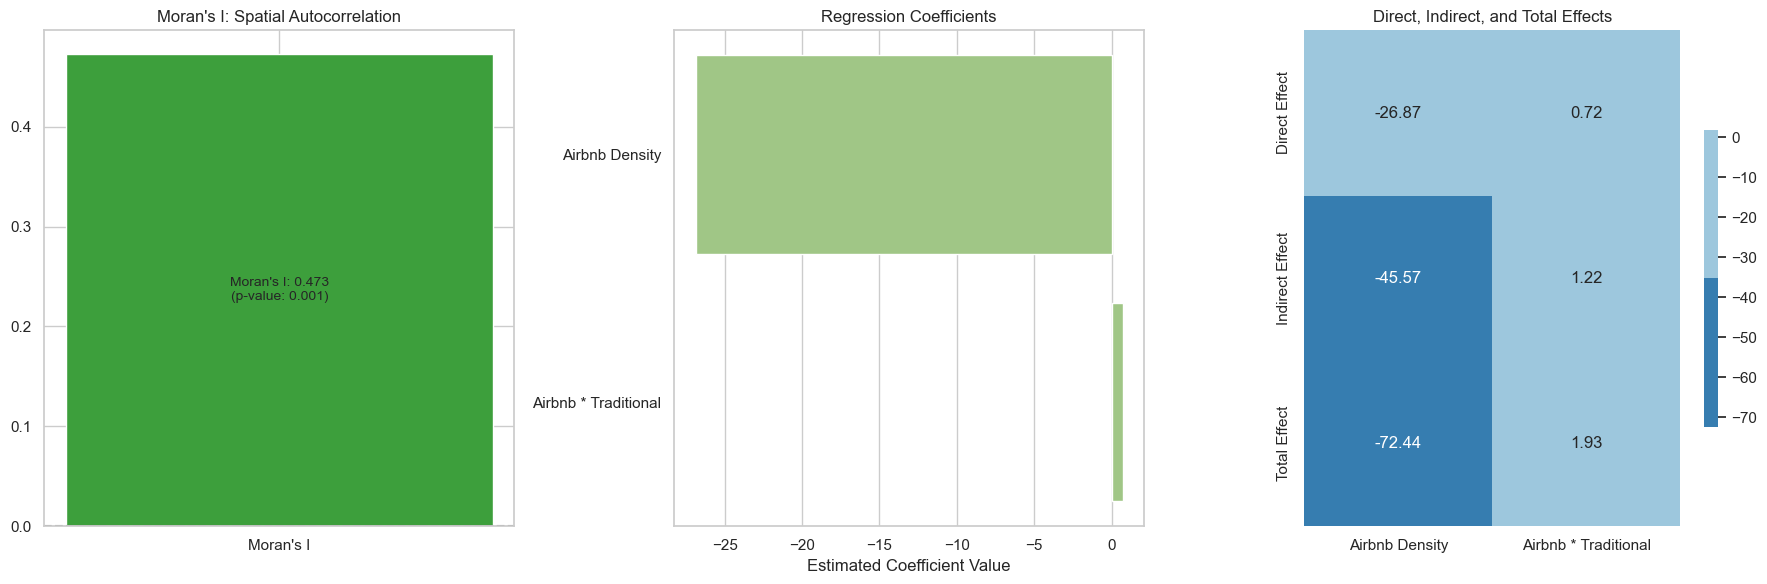

In [16]:
#| echo: false
#| warning: false
#| message: false
#| fig-width: 6
#| fig-height: 4

# Extract regression results
coefficients = [-26.87028, 0.71660]  # Coefficients for airbnb_density_per_ha and airbnb_interact
effect_direct = [-26.8703, 0.7166]   # Direct effects
effect_indirect = [-45.5687, 1.2153] # Indirect effects
effect_total = [-72.4390, 1.9319]    # Total effects

# Moran's I results
moran_i = 0.4728
p_value = 0.001

# Variable names
variable_names = ['Airbnb Density', 'Airbnb * Traditional']
effect_labels = ['Direct Effect', 'Indirect Effect', 'Total Effect']

# Custom colour palette
colour_moran = '#3D9F3C'    # Green for Moran's I
colour_bar = '#9ED17B'      # Light green for bar chart
colour_heatmap = ['#367DB0', '#9DC7DD']  # Blue tones for heatmap

# Set Seaborn style
sns.set(style="whitegrid")

# Create a single figure with three side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# 1. Visualise Moran's I result (spatial autocorrelation)
axes[0].bar(['Moran\'s I'], [moran_i], color=colour_moran)  # Bar chart for Moran's I
axes[0].axhline(y=0, color='grey', linestyle='--')  # Horizontal reference line
axes[0].text(0, moran_i / 2, f"Moran's I: {moran_i:.3f}\n(p-value: {p_value:.3f})", 
             ha='center', va='center', fontsize=10)  # Display Moran's I value
axes[0].set_title("Moran's I: Spatial Autocorrelation")  # Title for the first chart

# 2. Visualise regression coefficients
sns.barplot(x=coefficients, y=variable_names, orient='h', ax=axes[1], color=colour_bar)  # Horizontal bar chart
axes[1].set_xlabel("Estimated Coefficient Value")  # X-axis label
axes[1].set_title("Regression Coefficients")  # Title for the second chart

# 3. Visualise spatial effects (direct, indirect, and total)
effects = np.array([effect_direct, effect_indirect, effect_total])  # Combine effects into a matrix
sns.heatmap(effects, annot=True, fmt=".2f", cmap=sns.color_palette(colour_heatmap, as_cmap=True),
            ax=axes[2], yticklabels=effect_labels, xticklabels=variable_names, cbar_kws={'shrink': 0.6})
axes[2].set_title("Direct, Indirect, and Total Effects")  # Title for the heatmap

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the combined figure
plt.show()